# K-mean Algorithm


---


Applying the K-mean algorithm in our dataset to see how it would cluster the students data.




## Binary Dataset
Our dataset, for this study, is composed by rows of students (we anonymized the student IDs by replacing them with integers) and columns of classes.

We are not focusing on clustering based on raw grades (yet). Instead, we replaced the grades with binary values: 0 = failed and 1 = passed

In [1]:
import pandas as pd
import numpy as np


alunos = pd.read_csv('/content/dataset.csv')
alunos.head()


,ID,IM885,IM853,TN707,TN705,TN706,TN703
0,1,9.6,9.0,9.0,7.4,8.4,7.3
1,2,0.0,1.1,0.0,0.0,0.0,0.0
2,3,9.8,9.7,9.2,9.3,8.7,8.7
3,4,9.0,8.6,7.8,2.9,0.0,7.4
4,5,8.9,9.5,10.0,7.3,8.3,7.7


In [2]:
def approve_reprove(grade):
  return 1 if grade >= 5 else 0

In [3]:
features = ["IM885", "IM853", "TN707", "TN705", "TN706", "TN703"]  ## class code
alunos = alunos.dropna(subset=features)
data = alunos[features].copy()

# apply the approve_reprove function to the selected features
data = data.applymap(approve_reprove)

display(data)

/tmp/ipython-input-1391096145.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(approve_reprove)


,IM885,IM853,TN707,TN705,TN706,TN703
0,1,1,1,1,1,1
1,0,0,0,0,0,0
2,1,1,1,1,1,1
3,1,1,1,0,0,1
4,1,1,1,1,1,1
...,...,...,...,...,...,...
189,0,1,1,0,1,1
190,0,1,1,0,1,1
191,1,1,1,1,1,1
192,0,1,1,0,0,1


In [4]:
data.head()

,IM885,IM853,TN707,TN705,TN706,TN703
0,1,1,1,1,1,1
1,0,0,0,0,0,0
2,1,1,1,1,1,1
3,1,1,1,0,0,1
4,1,1,1,1,1,1


## Centroids

Centroids are the center points of each cluster, representing the average of all data points within that cluster.

They can be randomly generated (as for this code) or manually defined. The main challenge lies in deciding how many centroids to use, since this number also determines the number of clusters, which affects the level of pecision and relevance of the clustering.


In [5]:
def random_centroids(data, k):
  centroids = []
  for i in range(k):
    centroid = data.apply(lambda x: float(x.sample()))
    centroids.append(centroid)
  return pd.concat(centroids, axis=1)

In [6]:
centroids = random_centroids(data, 5)
centroids

/tmp/ipython-input-3306298238.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  centroid = data.apply(lambda x: float(x.sample()))


,0,1,2,3,4
IM885,0.0,1.0,0.0,1.0,1.0
IM853,1.0,1.0,1.0,1.0,1.0
TN707,1.0,1.0,1.0,1.0,0.0
TN705,1.0,1.0,0.0,0.0,0.0
TN706,1.0,0.0,1.0,1.0,0.0
TN703,1.0,1.0,1.0,1.0,1.0


In [7]:
def get_labels(data, centroids):
  distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2 ).sum(axis = 1)))
  return distances.idxmin(axis = 1)

In [8]:
labels = get_labels(data, centroids)
labels

,0
0,0
1,4
2,0
3,1
4,0
...,...
189,2
190,2
191,0
192,2


In [9]:
labels.value_counts()

,count
0,99
1,38
2,33
3,15
4,9


In [10]:
def new_centroids(data, labels, k):
    centroids = data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [12]:
def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def best_k(ks, wcss):
    p1 = np.array([ks[0], wcss[0]])
    p2 = np.array([ks[-1], wcss[-1]])

    def dist(p, a, b):
        # distância ponto-linha
        return np.abs(np.cross(b-a, a-p)) / np.linalg.norm(b-a)

    dists = [dist(np.array([ks[i], wcss[i]]), p1, p2) for i in range(len(ks))]
    return ks[int(np.argmax(dists))]

## Elbow Method

Defining the optimal number of clusters (k) is a critical step for the success of the k-means algorithm, as it directly influences the quality of the partitioning. One commonly used approach for this task is the Elbow Method, which evaluates the within-cluster sum of squares (WCSS) across different values of k and identifies the point where the marginal gain in variance reduction starts to diminish, suggesting an appropriate value for k.

However, the Elbow Method is not foolproof. In many cases, the “elbow” is not clearly distinguishable or may appear at multiple candidate values of k, leading to potential misinterpretation.
For this reason, it is often advisable to combine it with complementary techniques such as the Silhouette Score, Gap Statistic, or other cluster validity indices to achieve a more robust determination of the optimal number of clusters.

In [18]:
def elbow_method_sklearn(data, k_min=1, k_max=10):
    wcss = []
    ks = range(k_min, k_max+1)

    for k in ks:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)

    # gráfico
    plt.plot(ks, wcss, marker='o')
    plt.title('Elbow Method / Método do Cotovelo ')
    plt.xlabel('Número de clusters (k)')
    plt.ylabel('WCSS (inércia)')
    plt.show()

    return list(ks), wcss

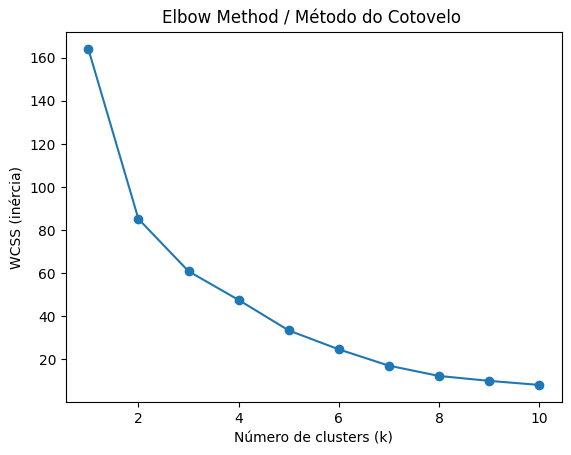

Número ótimo de clusters (cotovelo): 3


/tmp/ipython-input-516032263.py:11: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  return np.abs(np.cross(b-a, a-p)) / np.linalg.norm(b-a)


In [19]:
ks, wcss = elbow_method_sklearn(data, k_min=1, k_max=10)
melhor_k = best_k(ks, wcss)
print("Número ótimo de clusters (cotovelo):", melhor_k)

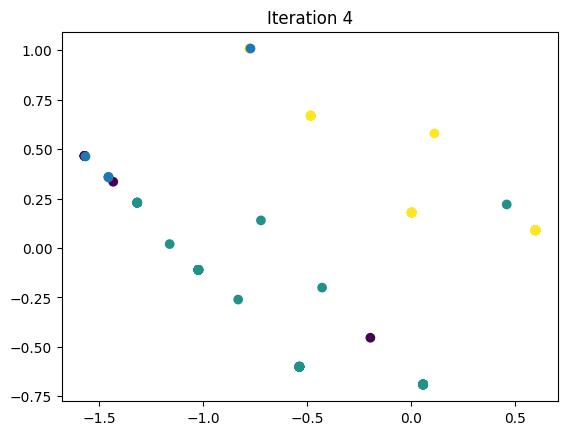

In [20]:
max_iterations = 100
centroid_count = 5

centroids = random_centroids(data, centroid_count)
old_centroids = pd.DataFrame()
iteration = 1

while iteration < max_iterations and not centroids.equals(old_centroids):
    old_centroids = centroids

    labels = get_labels(data, centroids)
    centroids = new_centroids(data, labels, centroid_count)
    plot_clusters(data, labels, centroids, iteration)
    iteration += 1

In [23]:
unique_labels = labels.unique()

for p in unique_labels:
  print(f"\nAlunos in Cluster {p}:")
  df = pd.DataFrame(alunos[labels == p][["ID"] + features])
  df.to_csv(f'cluster_{p}.csv', index=False)
  display(df)


Alunos in Cluster 4:


,ID,IM885,IM853,TN707,TN705,TN706,TN703
0,1,9.6,9.0,9.0,7.4,8.4,7.3
2,3,9.8,9.7,9.2,9.3,8.7,8.7
4,5,8.9,9.5,10.0,7.3,8.3,7.7
9,10,9.4,10.0,10.0,9.8,9.6,9.4
10,11,9.5,9.9,9.8,9.6,10.0,7.0
...,...,...,...,...,...,...,...
188,189,1.5,5.1,6.1,0.4,5.0,5.5
189,190,0.0,5.7,5.9,4.1,5.2,6.5
190,191,0.4,5.4,7.9,3.4,5.0,7.9
191,192,5.9,6.5,9.5,5.0,8.0,7.9



Alunos in Cluster 0:


,ID,IM885,IM853,TN707,TN705,TN706,TN703
1,2,0.0,1.1,0.0,0.0,0.0,0.0
8,9,0.0,0.0,0.0,0.0,0.0,0.0
18,19,5.8,7.4,0.0,6.0,1.5,0.0
50,51,0.0,0.0,0.0,0.0,0.0,2.9
55,56,0.0,1.3,0.0,0.0,0.0,0.0
114,115,1.0,2.1,4.3,0.0,0.0,0.0
127,128,1.0,1.6,6.9,0.4,0.8,4.1
165,166,0.0,0.0,0.0,0.0,0.0,0.0



Alunos in Cluster 2:


,ID,IM885,IM853,TN707,TN705,TN706,TN703
3,4,9.0,8.6,7.8,2.9,0.0,7.4
5,6,8.4,9.4,9.8,7.1,2.2,9.1
6,7,7.5,7.9,9.3,5.0,4.9,8.0
7,8,3.1,5.0,0.0,0.0,0.7,6.3
11,12,10.0,9.0,6.7,6.2,2.2,8.0
...,...,...,...,...,...,...,...
178,179,7.4,6.4,7.6,1.3,0.0,6.6
181,182,4.4,1.4,7.7,5.0,1.1,6.1
183,184,0.3,5.7,5.7,1.3,1.5,7.1
187,188,0.4,6.1,8.1,1.8,1.0,6.7


## Final analisis

### Prompt
Prompt we used when uploading the clusters to be analyzed by LLMS



Você é um analista de dados especializado em educação e mineração de dados. Sua tarefa é analisar os resultados de uma análise de cluster realizada com os dados de desempenho de alunos do primeiro período.

Contexto e Estrutura dos Dados:

    Fonte dos Dados: Uma única tabela matriz.

    Linhas: Cada linha representa um aluno único.

    Colunas: Cada coluna representa uma matéria específica do primeiro período.

    Valores: O valor em cada célula é binário:

        1 indica que o aluno foi aprovado naquela matéria.

        0 indica que o aluno foi reprovado (ou não aprovado) naquela matéria.

    Análise Prévia: Esta tabela foi processada por um algoritmo de clustering (como K-Means) que gerou duas versões de resultados:

        Cenário A: Os alunos foram agrupados em 3 clusters.

        Cenário B: Os alunos foram agrupados em 5 clusters.

    Dados Fornecidos: Você receberá duas tabelas (ou uma tabela com duas abas). Cada tabela contém os dados originais (alunos x matérias) com uma coluna adicional chamada Cluster, que identifica o grupo ao qual cada aluno foi atribuído (ex.: Cluster 0, Cluster 1, Cluster 2 para o caso de 3 clusters, e assim por diante).

Tarefa de Análise:

Para cada cenário (3 clusters e 5 clusters), realize as seguintes etapas:

1. Análise Descritiva por Cluster:
* Calcule a taxa média de aprovação por matéria dentro de cada cluster. (Ex: Para o Cluster 0, na matéria "Cálculo 1", 80% dos alunos têm valor 1).
* Identifique padrões de comportamento.
* Quais matérias têm as taxas de aprovação mais altas e mais baixas em cada grupo?
* Existe um cluster de "alunos com alto desempenho" que passaram em quase todas as matérias?
* Existe um cluster de "alunos com baixo desempenho" que foram reprovados na maioria das matérias?
* Existem clusters "intermediários" ou "específicos"? Por exemplo, um grupo que foi bem em exatas mas mal em humanas, ou vice-versa?
* Descreva, em português, o perfil de cada cluster com base nessas estatísticas. Dê um "nome" ou "rótulo" intuitivo para cada um (ex: "Os Excelentes", "Os com Dificuldade em Exatas", "Os que Strugglaram Globalmente").

2. Comparação e Conclusão Final:
* Compare os dois cenários (3 vs. 5 clusters).
* Inferir e Recomendar: Com base na sua análise, qual divisão foi mais útil e significativa? A de 3 ou a de 5 clusters?
* Justifique sua resposta detalhadamente. Considere os segu pontos:
* Clareza e Distinção: Os clusters no cenário de 5 grupos são bem delineados e oferecem insights novos e acionáveis, ou eles apenas fragmentam excessivamente grupos que já estavam claros no cenário de 3 clusters?
* Ação Prática: A divisão em 5 clusters ajudaria a universidade a criar programas de tutoria ou apoio mais específicos? Ou a divisão em 3 clusters já é suficiente para orientar políticas educacionais gerais?
* Simplicidade vs. Detalhe: O ganho em detalhe com 5 clusters compensa a perda de simplicidade e a possível maior dificuldade de interpretação?

Formato de Saída Esperado:
Por favor, estruture sua resposta da seguinte forma:
Análise de Clusters de Desempenho Acadêmico
1. Análise para 3 Clusters

    Cluster 0 (Sugira um Nome):

        Perfil: [Descrição clara do perfil de desempenho].

        Estatísticas Chave: [Cite 2-3 matérias com taxas de aprovação mais altas/baixas que definem o grupo].

    Cluster 1 (Sugira um Nome):

        Perfil: [Descrição clara...].

        Estatísticas Chave: [Cite 2-3 matérias...].

    Cluster 2 (Sugira um Nome):

        Perfil: [Descrição clara...].

        Estatísticas Chave: [Cite 2-3 matérias...].

2. Análise para 5 Clusters

    Cluster 0 (Sugira um Nome):

        Perfil: [Descrição clara...].

    Cluster 1 (Sugira um Nome):

        Perfil: [Descrição clara...].

    Cluster 2 (Sugira um Nome):

        Perfil: [Descrição clara...].

    Cluster 3 (Sugira um Nome):

        Perfil: [Descrição clara...].

    Cluster 4 (Sugira um Nome):

        Perfil: [Descrição clara...].

3. Conclusão e Recomendação

    Divisão Mais Eficaz: [3 clusters ou 5 clusters?]

    Justificativa:

        [Explique, com base nos perfis encontrados, por que uma divisão é superior à outra. Ex: "A divisão em 5 clusters identificou um subgrupo específico de alunos com dificuldade apenas em [Matéria X], o que é valioso para criar um workshop focado. Já a de 3 clusters agrupava esses alunos com um grupo maior e heterogêneo, mascarando essa necessidade." OU "Os 5 clusters apenas dividiram os grupos grandes de 3 clusters em subgrupos menores sem padrões de desempenho significativamente diferentes, tornando a análise mais complexa sem agregar valor real."].